# don't enter to this part,just run it!!

## import liberary and esential functions

In [1]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.colab import drive
import scipy.io
drive.mount('/content/drive')


Mounted at /content/drive


بخش استخراج داده  های پروژه از فایل های DPX

%%HTML
<div dir=rtl>
تابع اصلی اما برای استخراج داده های فایل های متلب تابع زیر یعنی DPXD  خواهد بود که خروجی آن یک دیکشنری با فیلد های زیر که تایپ آن نیز ذکر شده خواهد بود لذا برای استفاده اسان تر از داده ها از ابتدا فایل مربوطه را به تابع داده و از دیکشنری خروجی استفاده نمایید.
 <ul>
  <li>speeds : Numpy Array</li>
  <li>Id of Mouse: List </li>
  <li>Type of experiment: List</li>
  <li>Diameter of Points(Diams): Numpy Array </li>
  <li>Contrast of Points(Contrast) : Numpy Array </li>
</ul> 
</div>

In [2]:
#@title
def DPXD2Dict(f):
  p=f['C'][0,0]
  p1=p[0,0]
  size=p1[8][0][0]
  Id=[]
  Type=[]
  SpeedSign=[]
  Speed=p1[2][0]
  Yaw=[]
  Time=[]
  BAYASYAW=[]
  diam=p1[5][0]
  contrast=p1[6][0]
  std_level=[]
  for i in range(size):
    temp=p1[3][0][i][0].split("_")
    Id.append(temp[0])
    Type.append(temp[1])    
    if(Speed[i]==0):
      SpeedSign.append("sta")
    elif(Speed[i]<0):
      SpeedSign.append("neg")
    else:
      SpeedSign.append("pos")  
    Yaw.append(p1[7][0][i][0])
    Time.append(p1[1][0][i][0])
    BAYASYAW.append(p1[0][0][i][0])
    std_level.append(np.std(p1[7][0][i][0]))  
  data={"YAW":Yaw,"YAW_BAYAS":BAYASYAW,"YAW_Time":Time,"YAW_std_level":std_level,
        "speeds":Speed,"Id":Id,"Type":Type,"SignSpeed":SpeedSign,'Diams':diam,'Contrast':contrast}
  return data      

## load file

In [3]:
#@title
data={}
l=[[7,14,21],[8,15,22],[7,14,21],[8,16,23],[8,15,22]]

for i in range(len(l)):
  for j in range(1,l[i][2]+1):
    f=scipy.io.loadmat('/content/drive/My Drive/mouseProject/Speed/mouseNewData/W{}/{}.mat'.format(i+1,j))
    if(j<=l[i][0]):
      data[('W{}_BOTH'.format(i+1),j)]=DPXD2Dict(f)
    elif(j>l[i][0] and j<=l[i][1]):
      data[('W{}_LEFT'.format(i+1),j)]=DPXD2Dict(f)
    else:
      data[('W{}_RIGHT'.format(i+1),j)]=DPXD2Dict(f)

## converting the input


In [4]:
def minSize(l):
  t=1500
  for i in l:
    if(i.shape[0]<t):
      t=i.shape[0]
  return t 
#=========---------------------
def create_dict(l):
  my_dict={}
  for i in l:
    for j in l:
      my_dict[(i,j)]=[]

  return my_dict

def compare_cluster(types=['W1_BOTH'],ID=[3],ID_start=[0],threshold=10): # please add one type of mouce
  l=np.unique(data[('W1_BOTH',ID[0])]['speeds']) #check exist all speed
  single_mean_dict,Yaw_mean_dict,Yaw_mean_dict_Time = create_dict(l),create_dict(l),create_dict(l)
  
  p=-1
  for mouce_type in types:
    p+=1
    for w in range(1+ID_start[p],ID[p]+1+ID_start[p]):
      for i in range(1,data[(mouce_type,w)]['speeds'].shape[0]):
        # ignore outlier
        if data[(mouce_type,w)]['YAW_std_level'][i]> threshold and data[(mouce_type,w)]['YAW_std_level'][i-1]> threshold:   
          single_mean_dict[(data[(mouce_type,w)]['speeds'][i-1],data[(mouce_type,w)]['speeds'][i])].append(np.mean(data[(mouce_type,w)]['YAW'][i]))
          Yaw_mean_dict[(data[(mouce_type,w)]['speeds'][i-1],data[(mouce_type,w)]['speeds'][i])].append(data[(mouce_type,w)]['YAW'][i])
          Yaw_mean_dict_Time[(data[(mouce_type,w)]['speeds'][i-1],data[(mouce_type,w)]['speeds'][i])].append(data[(mouce_type,w)]['YAW_Time'][i])
  
  return Yaw_mean_dict_Time,Yaw_mean_dict,l
def find_standard_yaw(Yaw_mean_dict_Time,Yaw_mean_dict,l):

   #used to find first quadratics in order to have longer trials
  quadratics=create_dict(l)
  quadraticsVal=create_dict(l)
  for i in l:
    for j in l:
      quadratics[(i,j)]=(len(Yaw_mean_dict_Time[(i,j)])//4)
  for i in l:
    for j in l:
      temp=[]
      for k in range(len(Yaw_mean_dict_Time[(i,j)])):
        temp.append(Yaw_mean_dict_Time[(i,j)][k].shape[0])
      temp.sort()
      quadraticsVal[(i,j)]=temp[quadratics[(i,j)]]
  edited_yaw=create_dict(l)
  edited_time=create_dict(l)
  for i in l:
    for j in l:
      for k in range(len(Yaw_mean_dict_Time[(i,j)])):
        if(Yaw_mean_dict_Time[(i,j)][k].shape[0]>=quadraticsVal[(i,j)]):
          edited_yaw[(i,j)].append(Yaw_mean_dict[(i,j)][k])
          edited_time[(i,j)].append(Yaw_mean_dict_Time[(i,j)][k])
  Yaw_mean_dict=edited_yaw
  Yaw_mean_dict_Time=edited_time
  return Yaw_mean_dict

In [5]:
a,b,l=compare_cluster(['W1_BOTH','W2_BOTH','W3_BOTH','W4_BOTH','W5_BOTH'],[7,8,7,8,8],[0,0,0,0,0])
Yaw_mean_dict_BOTH =find_standard_yaw(a,b,l)

a,b,l=compare_cluster(['W1_LEFT','W2_LEFT','W3_LEFT','W4_LEFT','W5_LEFT'],[7,7,7,8,7],[7,8,7,8,8])
Yaw_mean_dict_LEFT =find_standard_yaw(a,b,l)

a,b,l=compare_cluster(['W1_RIGHT','W2_RIGHT','W3_RIGHT','W4_RIGHT','W5_RIGHT'],[7,7,7,7,7],[14,15,14,16,15])
Yaw_mean_dict_RIGHT =find_standard_yaw(a,b,l)

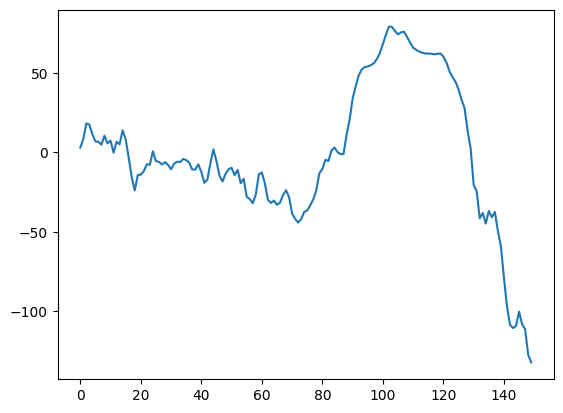

In [6]:
plt.plot(Yaw_mean_dict_BOTH[(+72, -72)][0])

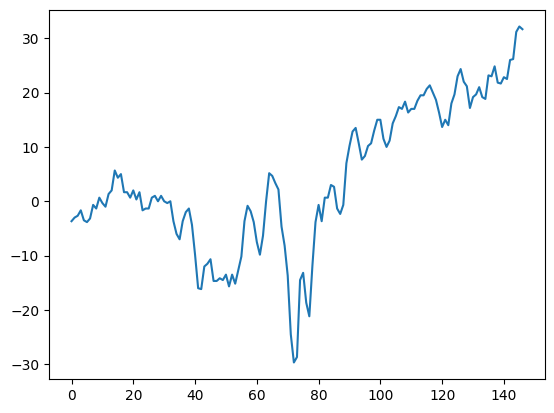

In [7]:
plt.plot(Yaw_mean_dict_BOTH[(+72, +72)][0])

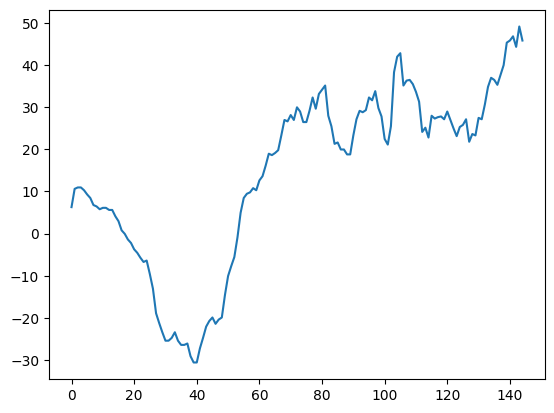

In [8]:
plt.plot(Yaw_mean_dict_BOTH[(-72, +72)][0])

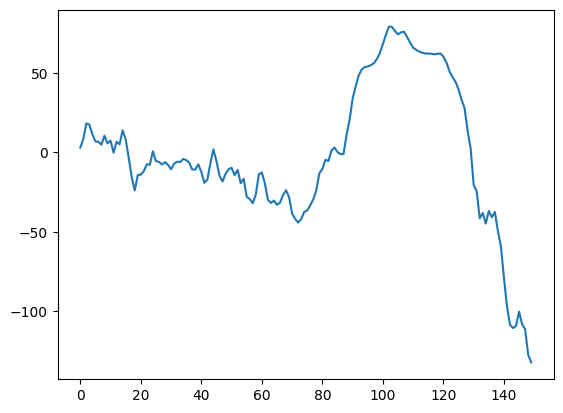

In [9]:
plt.plot(Yaw_mean_dict_BOTH[(+72, -72)][0])

#Creating DataSet


In [103]:
 %%capture
! pip install torchview

In [104]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
from torchvision import transforms
from torchview import draw_graph
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

In [130]:
class MouseDataset(torch.utils.data.Dataset):
  def __init__(self):
    pass
  def make_data_set(self,data, types = ['BOTH','LEFT','RIGHT'], mice = [i+1 for i in range(5)],prev_shift = 0, interval = [0,150],normalize = False, 
                    std_threshold = 10 ,speeds = [-72.0, -54.0 ,-36.0 , -18.0 ,0.0 ,72.0, 54.0 ,36.0 , 18.0]):
    l = [[7,14,21],[8,15,22],[7,14,21],[8,16,23],[8,15,22]]
    alltrials = []
    allspeeds = []
    nums = []
    for mouse in mice:
      for typ in types:
        if typ == 'BOTH':
          num = 0
      
        elif typ == 'LEFT':
          num = 1
          
        else:
          num = 2
        
        start = l[mouse-1][num-1]+1  if num != 0 else 1       
        for j in range(start,l[mouse-1][num]+1):
          alltrials.extend([data[(f'W{str(mouse)}_{typ}', j)]['YAW'][i] for i in range(len(data[(f'W{str(mouse)}_{typ}', j)]['YAW'])) 
          if data[(f'W{str(mouse)}_{typ}', j)]['speeds'][i] in speeds and data[(f'W{str(mouse)}_{typ}', j)]['YAW_std_level'][i]> std_threshold ]  )
          allspeeds.extend([data[(f'W{str(mouse)}_{typ}', j)]['SignSpeed'][i] for i in range(len(data[(f'W{str(mouse)}_{typ}', j)]['YAW'])) 
          if data[(f'W{str(mouse)}_{typ}', j)]['speeds'][i] in speeds and data[(f'W{str(mouse)}_{typ}', j)]['YAW_std_level'][i]> std_threshold])

          nums.extend([data[(f'W{str(mouse)}_{typ}', j)]['SignSpeed'][i] for i in range(len(data[(f'W{str(mouse)}_{typ}', j)]['YAW'])) 
          if data[(f'W{str(mouse)}_{typ}', j)]['SignSpeed'][i] in speeds])
      

      self.X, allspeeds = self.truncate(alltrials,allspeeds,nums,normalize) 
      t = np.array(allspeeds)
      b = t[:,np. newaxis]

      enc = OneHotEncoder()
      self.Y = enc.fit_transform(b).toarray()

    self.X = self.X[prev_shift:,interval[0]:interval[1]]
    self.X = self.X.reshape((self.X.shape[0],self.X.shape[1],1))
    self.X = np.apply_along_axis(self.smooth, axis=1, arr=self.X)
    self.Y = self.Y[:self.Y.shape[0]-prev_shift,:]
    

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, index):
    
    return self.X[index,:], self.Y[index,:]
  

  def smooth(self  ,x):
    size = 7
    sigma = 1
    kernel = np.arange(size)
    center = size // 2
    kernel -= center
    kernel = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(kernel**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)
    x_smooth = np.convolve(x, kernel, mode='same')
    return x_smooth  


  def truncate(self,alltrials,allspeeds,nums,normalize):
    max_length = max([arr.shape[0] for arr in alltrials])
    for i in range(len(alltrials)):
      
      norm = np.linalg.norm(alltrials[i])
      # normalize the array using L2 norm
      if normalize:
        normalized_arr = alltrials[i] / (norm+1e-9)
      else :
        normalized_arr = alltrials[i]

      alltrials[i] = np.pad(normalized_arr, (0, max_length - len(normalized_arr)), 'constant',constant_values=(normalized_arr[-1]))
      # if (np.std(alltrials[i]) < 10 ) and (allspeeds[i] != "sta"): # deleting outlier data!!!!!!!!
      #   np.delete(alltrials, i)
      #   np.delete(allspeeds, i)

      # alltrials[i] = np.pad(alltrials[i], (nums[i], 0), 'constant')
    output_array = np.array(alltrials)
    return output_array , allspeeds

In [131]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [132]:
interval = [60, 150]
input_size = 1
batch_size = 64
hidden_dim = 128
learning_rate = 0.005
epochs = 10
num_layers_lstm = 3
output_size = 2


In [133]:
mouseDs = MouseDataset()
mouseDs.make_data_set(data,prev_shift = 0, interval = interval,types = ['BOTH','LEFT'],speeds = [-72.0, -54.0 ,-36.0 , -18.0,72.0, 54.0 ,36.0 , 18.0])


In [134]:
train_size = int(0.9 * len(mouseDs))
test_size = len(mouseDs) - train_size
train_dataset, test_dataset = random_split(mouseDs, [train_size, test_size])
valid_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - valid_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])


In [135]:
print(len(mouseDs),len(test_dataset), len(train_dataset), len(valid_dataset))

16484 1649 13352 1483


##Data Loader

In [136]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)


In [137]:
for a,b in train_loader:
  None
  break

13.003793619625561
33.598276805362865
26.004192913197386
13.398304436987663


/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


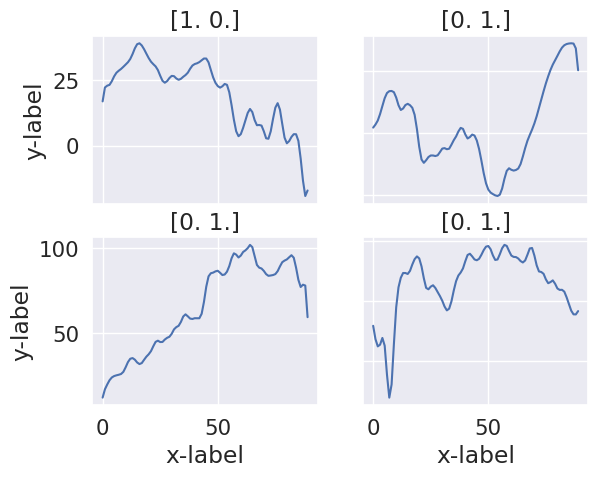

In [138]:
fig, axs = plt.subplots(2, 2)
random_number = np.random.randint(0,batch_size)

print(np.std(a[random_number,:,:].numpy()))
axs[0, 0].plot(a[random_number])
axs[0, 0].set_title(b[random_number].numpy())
random_number = np.random.randint(0,batch_size)
print(np.std(a[random_number,:,:].numpy()))
axs[0, 1].plot(a[random_number])
axs[0, 1].set_title(b[random_number].numpy())
random_number = np.random.randint(0,batch_size)
print(np.std(a[random_number,:,:].numpy()))
axs[1, 0].plot(a[random_number])
axs[1, 0].set_title(b[random_number].numpy())
random_number = np.random.randint(0,batch_size)
print(np.std(a[random_number,:,:].numpy()))
axs[1, 1].plot(a[random_number])
axs[1, 1].set_title(b[random_number].numpy())

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# RNN


In [139]:

# # Define LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(LSTMModel, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.output_size = output_size
#         self.bn = nn.BatchNorm1d(150) # 150 is time step

#         self.bilstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
#                             batch_first=True, dropout = 0.2, bidirectional = True)
#         self.seq = nn.Sequential(
#           nn.Linear(hidden_size * 2,512),
#           nn.ReLU(),
          
#           nn.Linear(512,512),
#           nn.Dropout(p=0.3),
#           nn.ReLU(),
          
#           nn.Linear(512, 128),
#           nn.ReLU(),
#           nn.Linear(128, output_size),
#           # nn.Softmax(dim=1)
#       )
        
        
#     def forward(self, x):
#         x = self.bn(x)
#         out1, _ = self.bilstm(x)
#         out2 = out1[:,-1,:]
        
#         out3 = self.seq(out2)
#         return out3
      


In [140]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(LSTMModel, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.output_size = output_size
#         self.bn = nn.BatchNorm1d(90) # 150 is time step
        
#         self.bilstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
#                             batch_first=True, dropout = 0.2, bidirectional = True)
#         self.attention = nn.MultiheadAttention(hidden_size*2, num_heads=4)  # Add attention layer with input size = hidden_size*2
#         self.seq = nn.Sequential(
#             nn.Linear(hidden_size * 2,512),
#             nn.ReLU(),

#             nn.Linear(512,512),
#             nn.Dropout(p=0.3),
#             nn.ReLU(),

#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Linear(128, output_size),
#             # nn.Softmax(dim=1)
#         )


#     def forward(self, x):
#         x = self.bn(x)
#         out1, _ = self.bilstm(x)
#         out1 = out1.transpose(0, 1)  # Transpose out1 to shape (seq_len, batch_size, hidden_size*2)
#         out2, _ = self.attention(out1, out1, out1)  # Apply attention mechanism to out1
#         out2 = out2[-1, :, :]  # Select the last output of attention mechanism
#         out3 = self.seq(out2)
#         return out3


In [141]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.bn = nn.BatchNorm1d(interval[1]-interval[0]) # 150 is time step
        self.attention = nn.MultiheadAttention(input_size, num_heads=1)

        # self.bilstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
        #                     batch_first=True, dropout = 0.2, bidirectional = True)
        # self.attention = nn.MultiheadAttention(input_size, num_heads=4)  # Add attention layer with input size = hidden_size*2
        self.seq = nn.Sequential(
            nn.Linear(input_size,512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.Dropout(p=0.3),
            nn.ReLU(),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.bn(x)
        # out1, _ = self.bilstm(x)
        out1 = x.transpose(0, 1)  # Transpose out1 to shape (seq_len, batch_size, hidden_size*2)
        out2, _ = self.attention(out1, out1, out1)  # Apply attention mechanism to out1
        out2 = out2[-1, :, :]  # Select the last output of attention mechanism
        out3 = self.seq(out2)
        return out3


# Define LSTM model

In [142]:
# Define LSTM model
model = LSTMModel(input_size=input_size, hidden_size = hidden_dim, num_layers = num_layers_lstm, output_size=output_size).to(device)

In [143]:
print(model)

LSTMModel(
  (bn): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1, out_features=1, bias=True)
  )
  (seq): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [144]:
model_graph = draw_graph(model, input_data=a.to(device).to(torch.float32), expand_nested=True,filename = 'modelDiagram',save_graph = True)


In [145]:
len(train_dataset)

13352

# Define loss function and optimizer

In [146]:

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Train model

In [147]:
# Train model
valid_loss = []
train_loss = []
num_epochs = 20
for epoch in range(num_epochs):
    tr_loss ,vl_loss = 0,0
    model.train()
    for inputs, targets in tqdm(train_loader):
      inputs= inputs.to(device)
      targets= targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs.to(torch.float32))
      loss = criterion(outputs, targets.to(torch.float32))
      
      tr_loss += loss * targets.shape[0]
      loss.backward()
      optimizer.step()

    model.eval()  
    with torch.no_grad():  
      for inputs, targets in tqdm(valid_loader): 
        inputs= inputs.to(device)
        targets= targets.to(device)
        outputs = model(inputs.to(torch.float32))
        loss = criterion(outputs, targets.to(torch.float32))
        vl_loss += loss * targets.shape[0]
    train_loss.append(tr_loss/len(train_dataset))
    valid_loss.append(vl_loss/len(valid_dataset))
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {valid_loss[-1].item():.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {train_loss[-1].item():.4f}")

100%|██████████| 24/24 [00:00<00:00, 582.42it/s]


Epoch [1/20], Train Loss: 0.5905
Epoch [1/20], Valid Loss: 0.6260


100%|██████████| 24/24 [00:00<00:00, 502.94it/s]


Epoch [2/20], Train Loss: 0.5835
Epoch [2/20], Valid Loss: 0.6042


100%|██████████| 24/24 [00:00<00:00, 559.21it/s]


Epoch [3/20], Train Loss: 0.5884
Epoch [3/20], Valid Loss: 0.6056


100%|██████████| 24/24 [00:00<00:00, 590.62it/s]


Epoch [4/20], Train Loss: 0.6031
Epoch [4/20], Valid Loss: 0.6036


100%|██████████| 24/24 [00:00<00:00, 459.74it/s]


Epoch [5/20], Train Loss: 0.5885
Epoch [5/20], Valid Loss: 0.6053


100%|██████████| 24/24 [00:00<00:00, 389.33it/s]


Epoch [6/20], Train Loss: 0.5832
Epoch [6/20], Valid Loss: 0.6039


100%|██████████| 24/24 [00:00<00:00, 611.56it/s]


Epoch [7/20], Train Loss: 0.5823
Epoch [7/20], Valid Loss: 0.6021


100%|██████████| 24/24 [00:00<00:00, 678.21it/s]


Epoch [8/20], Train Loss: 0.5894
Epoch [8/20], Valid Loss: 0.6037


100%|██████████| 24/24 [00:00<00:00, 612.55it/s]


Epoch [9/20], Train Loss: 0.5840
Epoch [9/20], Valid Loss: 0.5994


100%|██████████| 24/24 [00:00<00:00, 568.05it/s]


Epoch [10/20], Train Loss: 0.5814
Epoch [10/20], Valid Loss: 0.5999


100%|██████████| 24/24 [00:00<00:00, 589.73it/s]


Epoch [11/20], Train Loss: 0.5884
Epoch [11/20], Valid Loss: 0.5987


100%|██████████| 24/24 [00:00<00:00, 620.42it/s]


Epoch [12/20], Train Loss: 0.5906
Epoch [12/20], Valid Loss: 0.6027


100%|██████████| 24/24 [00:00<00:00, 609.57it/s]


Epoch [13/20], Train Loss: 0.5829
Epoch [13/20], Valid Loss: 0.5996


100%|██████████| 24/24 [00:00<00:00, 582.14it/s]


Epoch [14/20], Train Loss: 0.5849
Epoch [14/20], Valid Loss: 0.5994


100%|██████████| 24/24 [00:00<00:00, 639.26it/s]


Epoch [15/20], Train Loss: 0.5823
Epoch [15/20], Valid Loss: 0.6024


100%|██████████| 24/24 [00:00<00:00, 461.89it/s]


Epoch [16/20], Train Loss: 0.5810
Epoch [16/20], Valid Loss: 0.6015


100%|██████████| 24/24 [00:00<00:00, 416.32it/s]


Epoch [17/20], Train Loss: 0.5812
Epoch [17/20], Valid Loss: 0.6029


100%|██████████| 24/24 [00:00<00:00, 400.48it/s]


Epoch [18/20], Train Loss: 0.5835
Epoch [18/20], Valid Loss: 0.5990


100%|██████████| 24/24 [00:00<00:00, 642.48it/s]


Epoch [19/20], Train Loss: 0.5885
Epoch [19/20], Valid Loss: 0.5982


100%|██████████| 24/24 [00:00<00:00, 561.66it/s]

Epoch [20/20], Train Loss: 0.5814
Epoch [20/20], Valid Loss: 0.6016


In [148]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Get top-k predictions and associated indices
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # Check if each predicted index is in list of target indices
        correct = pred.eq(target.view(1, -1).expand_as(pred))
      
        # Calculate accuracy for each k valu
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res  

#the rest

In [149]:
with torch.no_grad():
  p=0
  p2=0
  for D_sample, labels in test_loader:
      
      D_sample, labels = D_sample.to('cuda'), labels.to('cuda')
      outputs = model(D_sample.to(torch.float32))
      
      t = (outputs.cpu().numpy().argmax(axis=1))
      t1 = (labels.cpu().numpy().argmax(axis=1))
      print(list(t))
      print(list(t1))
      p += np.sum(t == t1)
      p2 += t.shape[0]
      # print(accuracy(outputs ,labels))
      # print(np.sum(t == t1)/t.shape[0])
print(p)   
print(p2)  
print(p/p2)  

[1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 

In [150]:


def plot_confusion_matrix(predictions, labels, classes):
    """
    Plot the confusion matrix based on predictions and true labels.
    Args:
        predictions (Tensor): predicted labels
        labels (Tensor): true labels
        classes (list of str): class labels in ordered format
    """

    cm = confusion_matrix(labels, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the confusion matrix
    
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1.4)

    ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=False,
                     xticklabels=classes, yticklabels=classes, fmt='.2f', linewidths=.1)
    ax.set_xlabel('Prediction', fontsize=20, labelpad=20)
    ax.set_ylabel('True Label', fontsize=20, labelpad=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    plt.show()

#Plot loss

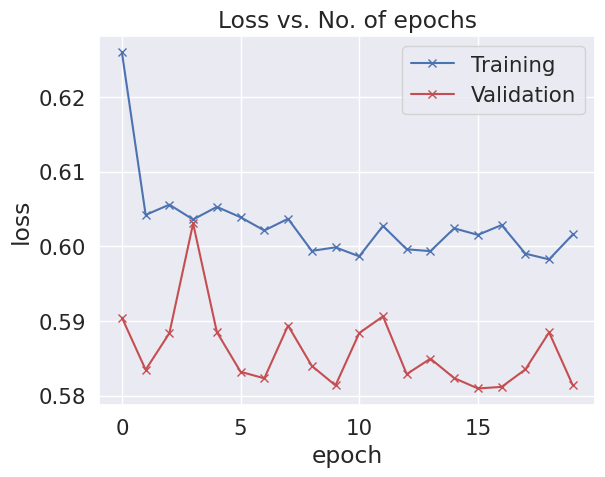

In [151]:
t_l=[float(a) for a in train_loss]
v_l=[float(a) for a in valid_loss]
plt.plot(t_l, '-bx')
plt.plot(v_l, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');
plt.show()

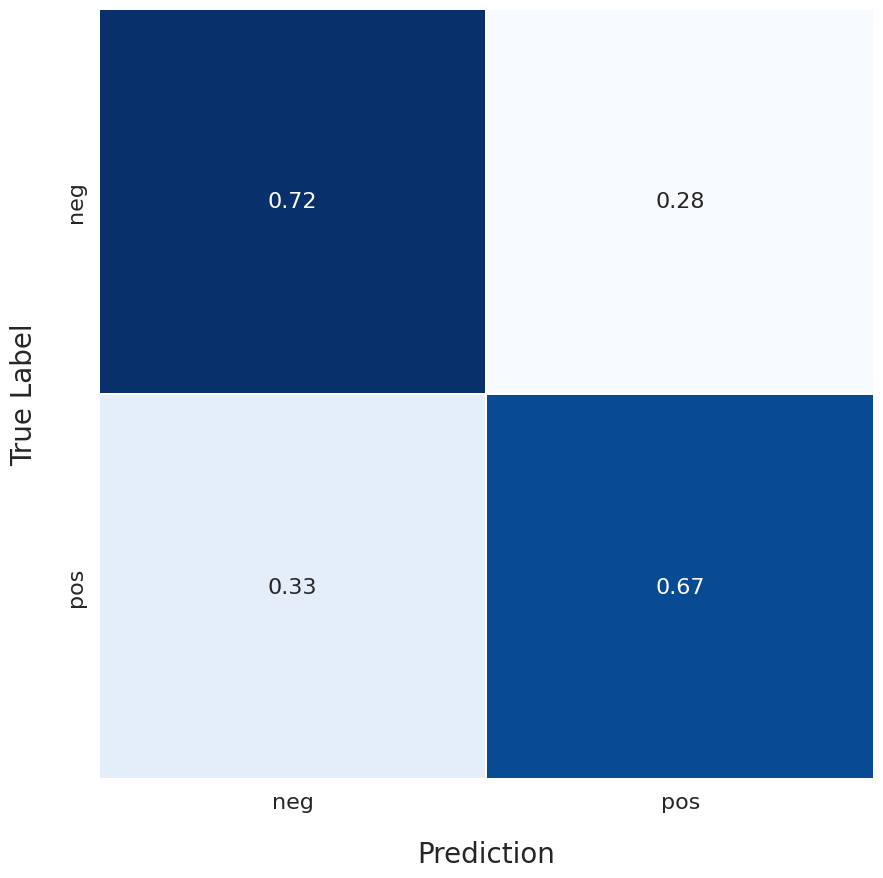

In [153]:
plot_confusion_matrix(t,t1,['neg','pos'])